## Homework (Mini-project)

Objective of this assignment is to implement the basic building blocks of a Deep Learning pipeline on a sample supervised-learning problem in **PyTorch**.



Name: Maximilian Forstenhaeusler

Matriculation No.: 03744460

**Important:** Do not forget to fill the places where you see `### Your code goes here ###`

______________

# Task and Setup

In this assignment, we want you to experience doing a mini-project in PyTorch. You are supposed to build the different parts of the pipeline as illustrated in the course notebooks (DataLoading, Model, Loss, Training, Evaluation). For this purpose, we will use a dataset from Quora containing question pairs and labels whether the pair is a duplicate or not.

The data can be found in Moodle in a csv file. The data is This data is subject to Quora's [Terms of Service](https://www.quora.com/about/tos), allowing for non-commercial use. The dataset was downloaded from https://www.kaggle.com/quora/question-pairs-dataset. 



**Classifiying Duplicate Question Pairs** 


We want to build a DL Model that can predict whether two questions from a Quora dataset are duplicates or not. Note that the two questions must not be identical as you will see in the dataset, rather they semantically mean almost the same thing.

To make the setup a bit simpler, we extracted and prepared a small subset of the original data consisting of 50k examples. Additionally, we removed questions that are too long or too short, we kept questions of length between 30 and 50 characters. Those 50k examples should serve as training and validation data, please consider making a reasonable split. Do not train on the validation data, just use it to evaluate your model.

**Model Inputs and Label**:

Input Format: 2 questions, for each question you will have an input of `BATCH_SIZE X SEQ_LEN`, where SEQ_LEN is the number of tokens in the question. Of course, if you will stack the input into batches, you will need to pad the questions (i.e. add a padding token or zeros at the end of the question to make all questions equal in length).

Label Format: `BATCH_SIZE X 1`, please note that the extra dimension (`X 1`) is optional and dependent on your implementaiton, you could have a simple 1D tensor of length `BATCH_SIZE`, where each value is either 0 or 1 indicating that the two questions are either non-duplicates or not, respectively.

**Hints:**

1. Please read the csv file and explore the dataset a bit in order to familize yourself with the problem before working on it.

2. In your custom DataLoader you have to make sure that you provide two questions for each example, this should be done in the `def __getitem__(self, idx)` method.

3. Please work at the word-level, your tokens are words. You will need to preprocess the data accordingly. Feel free to write simple Python code that can do the job, but also consider using tokenizers, stemmers, and lemmatizers from known NLP libraries such as [NLTK](https://www.nltk.org/) or [SpaCy](https://spacy.io/).

4. You will need to encode the words into integers to be able to pass them to the model, you will also need to keep track of the vocabulary. For this purpose, you can also write your own Python code or use an out-of-the-box module such as `torchtext.data.vocab` (see example in the data loading notebook). You can include this part in your Dataset class if you like.

5. You will most probalby need to use an embedding layer as input to the model, it will then take the sequence of integers and return numeric vectors representing each word. Please consider using pre-trained embeddings, there are multiple ways how to load these into your newly-created Embedding layer, `torchtext` also provides some easy ways to do that.

6. With Embeddings, you will have two options:
    - train your own embeddings on the task, either by starting from random weights or after loading pre-trained embeddings (this will take more time and probably need Colab or GPU)
    - or freeze the pre-trained embeddings and train the rest of the network (make sure the embedding layer is frozen, `requires_grad` is set to `False`.

7. Note that you will need to encode the questions as integers based on the vocabulary you are using. This sequence of integers will be fed as input to the model (embeddings lookup, then the following layers).

8. Take care that the model have two inputs (two sentences in parallel). This should be done in your implementation of the `def forward(self, question1, qustion2)` in your custom model class.

9. Since you need to feed both question to your model, in the `forward` you will have to let each question go through a couple of layers to get a representation for each question. Then, you will have to combine the two representations in any way you see possible (e.g. multiply them, subtract them, concatenate them). Finally, with this final representation, you will have to let it go through a couple of layers (mostly fully-connected layers) and then predict the outcome (2 classes).

10. This is generally a binary classification problem, you can use a classification loss to train your model. There are more advanced loss functions that are related to Siamese Networks (which is this architecture since it has multiple parallel inputs), feel free to use or explore them.

11. A nice lecture about the topic is here: Siamese Networks and Similarity Learning Lecture, Prof. Dr. Laura Leal-Taixé, Advanced Deep Learning for Computer Vision Course:https://www.youtube.com/watch?v=6e65XfwmIWE

12. Good summary and course notes of Deep Learning specialization on Coursera: https://github.com/mbadry1/DeepLearning.ai-Summary

### Introduction (Comments for running)

I implemented a Siamese LSTM Network to solve this task using pre-trained embedded weights. I used the `GoogleNews-vectors-negative300.bin` embeddings to create the pre-trained embedded weights. <br><br>
Because the Google Embeddings are soo large (3 billion entries I think), I created a weight tensor and stored it, `pretrained_weight.pt`. Instead of recreating a new weight tensor each time this notebook is run, as the vocabulary does not change, I load the stored pre-trained weigths tensor. The function how the pre-trained weights tensor is created can be found in `.model.utils.py.`<br>

Please keep the variable, `log_to_wandb = False` (hparams) when you are running this notebook in google collab. The runtime on cpu for 50 epochs is about 20 minutes.  

Please adjust the file path (`DATASET_FILE_PATH`) to where your data file is stored.

You can access the my wandb dashboard here: https://wandb.ai/maxifor/IBM-Praktikum%20Homework%202?workspace=user-maxifor

In [1]:
from homework_code.dataset.quora_dataset import QuoraDataset, collate
from homework_code.dataset.utils import convert_data_to_tuples, text_to_wordlist
from homework_code.dataset.language import Language
from homework_code.model.network import EmbeddingLSTMNet, SiameseNetwork
from homework_code.model.model_trainer import ModelTrainer
from homework_code.model.utils import create_pretrained_weights, plotConfusionMatrix, save_model
import os
import pandas as pd
import numpy as np
import wandb

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, SubsetRandomSampler

%load_ext autoreload

%autoreload 2

#### Global varibles

In [2]:
# Root and directory paths 
ROOT_PATH = os.getcwd()
DATA_FOLDER_PATH = ROOT_PATH + '/data'
GOOGLE_EMBEDDING_FOLDER_PATH = DATA_FOLDER_PATH + '/google embedding'
GOOGLE_EMBEDDING = GOOGLE_EMBEDDING_FOLDER_PATH + '/GoogleNews-vectors-negative300.bin'
MODEL_FOLDER_PATH = ROOT_PATH 
# important paths 
DATASET_FILE_PATH = DATA_FOLDER_PATH + '/mini_quora_dataset_30_50_50k.csv'
EMBEDDING_PATH = GOOGLE_EMBEDDING_FOLDER_PATH + GOOGLE_EMBEDDING

# general variables
EMBEDDING_REQUIRES_GRAD = False
NUM_LAYERS = 1

#### Hyperparameters 

In [3]:
# hyperperameters 

hparams = {
    'threshold': torch.Tensor([0.5]),
    'learning_rate': 1e-03,
    'epoch': 50,
    'batch_size': 32,
    'hidden_dim': 100,
    'embedding_dim': 300,
    'dropout': 0.0,
    'remove_stopwords': False,
    'stem_words': False,
    'simple': True,
    'log_to_wandb': True,
}

### Task 1: Data Loading (30 Points)

1. Write code to read the dataset after you download it from Moodle.
2. Explore some examples and check if you need to do some data cleaning or remove some bad examples.
3. Decide on what preprocessing steps you will do to the text of the questions.
4. Build a custom PyTorch dataset where you implement the required methods `__getitem__` and `__len__`. Do not forget to integrate any preprocessing steps in the class. Make sure that you also have a function that applies the whole preprocessing to a raw example, this will be very helpful when you want to predict for test examples later.
5. Split the data into train and validation data. Use a reasonable split ratio.
6. Create PyTorch dataloaders for train and validation datasets.

In [4]:
### Your code goes here ####
# all my code is in a seperate python package (homework_code) attached to the submission 

#### Load csv file 

In [5]:
df = pd.read_csv(DATASET_FILE_PATH)
df

,id,qid1,qid2,question1,question2,is_duplicate,max_length
0,307549,603786,603787,What are some different ways to make money fast?,What are fast ways to make money?,1,48
1,221916,437426,437427,How can I continue to improve my English?,How can I understand english?,1,41
2,177830,351280,351281,How do I promote my youtube videos?,What is the best way to promote YouTube videos?,1,47
3,128018,253605,253606,How can I organize a Quora Meetup in Pune?,Is there a Pune Quora Meetup group?,0,42
4,177761,351144,351145,What is the most badass moment of Game of Thro...,Who will die in season 5 of Game of Thrones?,0,50
...,...,...,...,...,...,...,...
49995,95213,189005,189006,How does drop shipping work exactly?,What is drop shipping and how does it work?,1,43
49996,62682,124658,124659,What are the best movies to watch in Hollywood?,Which are the best Hollywood movies of all time?,1,48
49997,109939,218008,218009,"Am I a sociopath, schizoid, or neither?",Am I a sociopath?,0,39
49998,370854,725712,725713,What is your marketing strategy?,What is a market strategy?,0,32


In [6]:
# select question pairs and labels
q_pair, labels = convert_data_to_tuples(df, hparams['remove_stopwords'], hparams['stem_words'])


Question Pairs:  49999


#### Create Languages

In [7]:
language = Language()
for data in [q_pair]:
    for question_pair in data:
        q1 = question_pair[0]
        q2 = question_pair[1]
        language.addSentence(q1)
        language.addSentence(q2)

#### Load Dataset 

In [8]:
quora_dataset = QuoraDataset(q_pair, language.word2index, labels)

In [9]:
# example 
for sample in quora_dataset:
    print('question 1:', sample['q1'])
    print('question 2:', sample['q2'])
    print('tokens  q1:', sample['q1_token'])
    print('tokens  q2:', sample['q2_token'])
    print('labels    :', sample['labels'])
    break

question 1: what are some different ways to make money fast
question 2: what are fast ways to make money
tokens  q1: [1, 2, 3, 4, 5, 6, 7, 8, 9]
tokens  q2: [1, 2, 9, 5, 6, 7, 8]
labels    : 1


#### Load DataLoaders

In [10]:
train_split = 0.8
val_split = 0.2

dataset_size = len(quora_dataset)
indices = list(range(dataset_size))

split_train = int(train_split*dataset_size)

shuffle_dataset = True
random_seed = 46

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[:split_train], indices[split_train:]

assert len(train_indices) + len(val_indices) == dataset_size

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
#test_sampler = SubsetRandomSampler(test_indices)

train_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=hparams['batch_size'], sampler=train_sampler, collate_fn=collate)
val_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=hparams['batch_size'], sampler=val_sampler, collate_fn=collate)
#test_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=hparams['batch_size'], sampler=test_sampler, collate_fn=collate)

#test_predict_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=1, sampler=test_sampler, collate_fn=collate)

print('Training Set Size {}, Validation Set Size {},'.format(len(train_indices), len(val_indices)))


Training Set Size 39999, Validation Set Size 10000,


### Task 2: Model (20 Points)

1. Explore what possible models for the task could be. You do not need to come up with a very complex model, a relatively small model consisting of the following sequence would be okay: {*Embeddings for the input - LSTM or CNN to process the sequence - Linear Layers to learn features from the combined representation of the questions - Output Layer*} would also be fine, just take care of the sizing of the different layers. Please always check the sizing after each layer and make sure you understand the dimensions correclty and they map to what you have in mind.
2. Build a model class.
3. Test your model with one batch from your dataloader and check the input and output shapes.

In [11]:
### Your code goes here ####

In [12]:
# create pretrained weights 
# skip this step because time consuming and might make cpu brake
# instead import the pretrained_weights.pt (see additional comments in at the top)

# pretrained_weights = create_pretrained_weights(GOOGLE_EMBEDDING, EMBEDDING_DIMENSION, language)
# pretrained_weights

In [13]:
pretrained_weights = torch.load('pretrained_weights.pt')
pretrained_weights

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1396, -0.0062,  0.2148,  ...,  0.0571,  0.0996, -0.2344],
        [-0.0967, -0.0264,  0.0903,  ..., -0.0197,  0.2139,  0.1367],
        ...,
        [-0.2100, -0.3711, -0.1211,  ..., -0.0066,  0.0742, -0.0233],
        [-0.1348, -0.0233, -0.0640,  ...,  0.2051,  0.1226, -0.1250],
        [-0.0381, -0.1445,  0.1426,  ...,  0.0216,  0.0688,  0.0171]])

#### Model 

In [14]:
# embedding net
embedding_net = EmbeddingLSTMNet(
    hparams['embedding_dim'],
    hparams['hidden_dim'],
    NUM_LAYERS,
    EMBEDDING_REQUIRES_GRAD,
    pretrained_weights,
    hparams['dropout'],
    hparams['simple'], # if simple=True --> simple model, if simple=False --> more complex model (2 linear layers plus relu)
)

# siamese model
model = SiameseNetwork(embedding_net)

In [15]:
# test model class with one batch from the dataloader 
for i, batch in enumerate(train_dataloader):
    q1, q2 = batch['q1_token'], batch['q2_token']
    q1_len, q2_len = batch['q1_lengths'], batch['q2_lengths']
    y = torch.FloatTensor(batch['labels'])

model(q1, q2, q1_len, q2_len)

tensor([1.2463e-01, 2.9048e-01, 7.3643e-01, 4.9852e-02, 2.2811e-04, 2.4283e-02,
        4.4411e-03, 3.1908e-05, 1.7725e-03, 1.9039e-01, 1.7178e-04, 8.3238e-03,
        1.1665e-01, 1.3213e-02, 1.0374e-01, 2.7834e-04, 2.9381e-04, 8.5191e-07,
        3.6771e-03, 3.0912e-01, 4.0798e-02, 3.1815e-01, 7.6843e-03, 2.5006e-02,
        1.8881e-02, 6.0260e-03, 5.7669e-04, 1.5585e-06, 4.8929e-02, 1.1621e-04,
        8.2544e-01], grad_fn=<CopySlices>)

### Task 3: Training (30 Points)

1. Develop Training and Validation code.
2. Choose a suitable loss function.
3. Refactor the code so that it can be easily modified and adapted (use methods, classes, etc...)
4. Make sure to save your trained model when you reach a good score on the validation dataset.
5. Plot the training and validation losses.

In [16]:
### Your code goes here ####

In [17]:
trainer = ModelTrainer(
    model, 
    hparams, 
    train_dataloader, 
    val_dataloader,
    train_indices, 
    val_indices,
    log_to_wandb=hparams['log_to_wandb'],
)

/Users/Maxi/opt/anaconda3/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:18: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,
wandb: Currently logged in as: maxifor (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [18]:
trainer.fit()

Epoch [1/50]  Training: 100%|██████████| 1250/1250 [00:36<00:00, 33.85batch/s, train_acc=78.125 %, train_loss=0.213]


Epoch [1/50] Validation: val_loss: 0.18973050614039358 val_acc: 72.43 %


Epoch [2/50]  Training: 100%|██████████| 1250/1250 [00:36<00:00, 34.55batch/s, train_acc=81.25 %, train_loss=0.177] 


Epoch [2/50] Validation: val_loss: 0.17838695128790485 val_acc: 74.32 %


Epoch [3/50]  Training: 100%|██████████| 1250/1250 [00:37<00:00, 33.57batch/s, train_acc=84.375 %, train_loss=0.165]


Epoch [3/50] Validation: val_loss: 0.17314270100654505 val_acc: 75.26 %


Epoch [4/50]  Training: 100%|██████████| 1250/1250 [00:39<00:00, 31.82batch/s, train_acc=81.25 %, train_loss=0.158] 


Epoch [4/50] Validation: val_loss: 0.16942250788116608 val_acc: 76.27000000000001 %


Epoch [5/50]  Training: 100%|██████████| 1250/1250 [00:37<00:00, 33.21batch/s, train_acc=78.125 %, train_loss=0.152]


Epoch [5/50] Validation: val_loss: 0.16775591381060811 val_acc: 76.16000000000001 %


Epoch [6/50]  Training: 100%|██████████| 1250/1250 [00:37<00:00, 33.74batch/s, train_acc=75.0 %, train_loss=0.148]  


Epoch [6/50] Validation: val_loss: 0.16556823877290414 val_acc: 76.81 %


Epoch [7/50]  Training: 100%|██████████| 1250/1250 [00:35<00:00, 35.13batch/s, train_acc=81.25 %, train_loss=0.144] 


Epoch [7/50] Validation: val_loss: 0.1646968228653216 val_acc: 76.91 %


Epoch [8/50]  Training: 100%|██████████| 1250/1250 [00:36<00:00, 34.67batch/s, train_acc=71.875 %, train_loss=0.141]


Epoch [8/50] Validation: val_loss: 0.1634433264025865 val_acc: 77.25 %


Epoch [9/50]  Training: 100%|██████████| 1250/1250 [00:37<00:00, 33.75batch/s, train_acc=81.25 %, train_loss=0.138] 


Epoch [9/50] Validation: val_loss: 0.1627861496549064 val_acc: 77.57 %


Epoch [10/50]  Training: 100%|██████████| 1250/1250 [00:36<00:00, 34.51batch/s, train_acc=81.25 %, train_loss=0.136] 


Epoch [10/50] Validation: val_loss: 0.1622017966910673 val_acc: 77.44 %


Epoch [11/50]  Training: 100%|██████████| 1250/1250 [00:36<00:00, 34.00batch/s, train_acc=78.125 %, train_loss=0.134]


Epoch [11/50] Validation: val_loss: 0.16137812308038765 val_acc: 77.55 %


Epoch [12/50]  Training: 100%|██████████| 1250/1250 [00:36<00:00, 33.79batch/s, train_acc=81.25 %, train_loss=0.132] 


Epoch [12/50] Validation: val_loss: 0.1609351500487937 val_acc: 77.41 %


Epoch [13/50]  Training: 100%|██████████| 1250/1250 [00:35<00:00, 34.83batch/s, train_acc=84.375 %, train_loss=0.13]


Epoch [13/50] Validation: val_loss: 0.1605716118464074 val_acc: 77.48 %


Epoch [14/50]  Training: 100%|██████████| 1250/1250 [00:35<00:00, 35.00batch/s, train_acc=75.0 %, train_loss=0.129]  


Epoch [14/50] Validation: val_loss: 0.16009698558253602 val_acc: 77.53 %


Epoch [15/50]  Training: 100%|██████████| 1250/1250 [00:38<00:00, 32.22batch/s, train_acc=78.125 %, train_loss=0.127]


Epoch [15/50] Validation: val_loss: 0.16023091307749002 val_acc: 77.49000000000001 %


Epoch [16/50]  Training: 100%|██████████| 1250/1250 [00:38<00:00, 32.69batch/s, train_acc=87.5 %, train_loss=0.126]  


Epoch [16/50] Validation: val_loss: 0.15983685905845782 val_acc: 77.61 %


Epoch [17/50]  Training: 100%|██████████| 1250/1250 [00:33<00:00, 36.98batch/s, train_acc=78.125 %, train_loss=0.125]


Epoch [17/50] Validation: val_loss: 0.15980664126503583 val_acc: 77.63 %


Epoch [18/50]  Training: 100%|██████████| 1250/1250 [00:38<00:00, 32.67batch/s, train_acc=78.125 %, train_loss=0.124]


Epoch [18/50] Validation: val_loss: 0.1593613652423167 val_acc: 77.64 %


Epoch [19/50]  Training: 100%|██████████| 1250/1250 [00:41<00:00, 29.89batch/s, train_acc=84.375 %, train_loss=0.123]


Epoch [19/50] Validation: val_loss: 0.15893635018088947 val_acc: 77.66 %


Epoch [20/50]  Training: 100%|██████████| 1250/1250 [00:39<00:00, 31.50batch/s, train_acc=78.125 %, train_loss=0.122]


Epoch [20/50] Validation: val_loss: 0.15898267798625623 val_acc: 77.73 %


Epoch [21/50]  Training: 100%|██████████| 1250/1250 [00:39<00:00, 31.30batch/s, train_acc=81.25 %, train_loss=0.121]


Epoch [21/50] Validation: val_loss: 0.15920295959082656 val_acc: 77.74 %


Epoch [22/50]  Training: 100%|██████████| 1250/1250 [00:35<00:00, 35.11batch/s, train_acc=81.25 %, train_loss=0.121]


Epoch [22/50] Validation: val_loss: 0.1586328907944143 val_acc: 77.7 %


Epoch [23/50]  Training: 100%|██████████| 1250/1250 [00:37<00:00, 33.75batch/s, train_acc=84.375 %, train_loss=0.12]


Epoch [23/50] Validation: val_loss: 0.15853497669243585 val_acc: 77.8 %


Epoch [24/50]  Training: 100%|██████████| 1250/1250 [00:36<00:00, 34.40batch/s, train_acc=81.25 %, train_loss=0.12] 


Epoch [24/50] Validation: val_loss: 0.15856002609188946 val_acc: 77.66999999999999 %


Epoch [25/50]  Training: 100%|██████████| 1250/1250 [00:35<00:00, 34.97batch/s, train_acc=84.375 %, train_loss=0.119]


Epoch [25/50] Validation: val_loss: 0.1584977205045307 val_acc: 77.75999999999999 %


Epoch [26/50]  Training: 100%|██████████| 1250/1250 [00:36<00:00, 34.54batch/s, train_acc=87.5 %, train_loss=0.119] 


Epoch [26/50] Validation: val_loss: 0.15823650424377605 val_acc: 77.84 %


Epoch [27/50]  Training: 100%|██████████| 1250/1250 [00:37<00:00, 33.26batch/s, train_acc=87.5 %, train_loss=0.118]  


Epoch [27/50] Validation: val_loss: 0.15885921291554697 val_acc: 77.79 %


Epoch [28/50]  Training: 100%|██████████| 1250/1250 [00:35<00:00, 35.63batch/s, train_acc=93.75 %, train_loss=0.118] 


Epoch [28/50] Validation: val_loss: 0.15836900839219079 val_acc: 77.75 %


Epoch [29/50]  Training: 100%|██████████| 1250/1250 [00:37<00:00, 33.36batch/s, train_acc=96.875 %, train_loss=0.118]


Epoch [29/50] Validation: val_loss: 0.15851700460663237 val_acc: 77.8 %


Epoch [30/50]  Training: 100%|██████████| 1250/1250 [00:36<00:00, 34.15batch/s, train_acc=84.375 %, train_loss=0.117]


Epoch [30/50] Validation: val_loss: 0.158527193763576 val_acc: 77.7 %


Epoch [31/50]  Training: 100%|██████████| 1250/1250 [00:36<00:00, 33.90batch/s, train_acc=81.25 %, train_loss=0.117]


Epoch [31/50] Validation: val_loss: 0.15831023499893304 val_acc: 77.86 %


Epoch [32/50]  Training: 100%|██████████| 1250/1250 [00:35<00:00, 35.51batch/s, train_acc=87.5 %, train_loss=0.117]  


Epoch [32/50] Validation: val_loss: 0.1582283236967108 val_acc: 77.84 %


Epoch [33/50]  Training: 100%|██████████| 1250/1250 [00:38<00:00, 32.07batch/s, train_acc=81.25 %, train_loss=0.117] 


Epoch [33/50] Validation: val_loss: 0.15821933643981673 val_acc: 77.75999999999999 %


Epoch [34/50]  Training: 100%|██████████| 1250/1250 [00:33<00:00, 37.82batch/s, train_acc=81.25 %, train_loss=0.116] 


Epoch [34/50] Validation: val_loss: 0.15823161785309306 val_acc: 77.81 %


Epoch [35/50]  Training: 100%|██████████| 1250/1250 [00:34<00:00, 36.51batch/s, train_acc=93.75 %, train_loss=0.116] 


Epoch [35/50] Validation: val_loss: 0.15808086685193612 val_acc: 77.8 %


Epoch [36/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.08batch/s, train_acc=93.75 %, train_loss=0.116]


Epoch [36/50] Validation: val_loss: 0.15823743516168656 val_acc: 77.78 %


Epoch [37/50]  Training: 100%|██████████| 1250/1250 [00:37<00:00, 33.73batch/s, train_acc=87.5 %, train_loss=0.116] 


Epoch [37/50] Validation: val_loss: 0.15821202365925519 val_acc: 77.79 %


Epoch [38/50]  Training: 100%|██████████| 1250/1250 [00:36<00:00, 34.65batch/s, train_acc=90.625 %, train_loss=0.115]


Epoch [38/50] Validation: val_loss: 0.1582144344814669 val_acc: 77.82 %


Epoch [39/50]  Training: 100%|██████████| 1250/1250 [00:35<00:00, 34.73batch/s, train_acc=87.5 %, train_loss=0.115]  


Epoch [39/50] Validation: val_loss: 0.15820031520276787 val_acc: 77.8 %


Epoch [40/50]  Training: 100%|██████████| 1250/1250 [00:37<00:00, 33.33batch/s, train_acc=90.625 %, train_loss=0.116]


Epoch [40/50] Validation: val_loss: 0.15815879334323704 val_acc: 77.81 %


Epoch [41/50]  Training: 100%|██████████| 1250/1250 [00:35<00:00, 34.84batch/s, train_acc=90.625 %, train_loss=0.115]


Epoch [41/50] Validation: val_loss: 0.15809458879807506 val_acc: 77.82 %


Epoch [42/50]  Training: 100%|██████████| 1250/1250 [00:33<00:00, 36.96batch/s, train_acc=87.5 %, train_loss=0.115]  


Epoch [42/50] Validation: val_loss: 0.1581059260109362 val_acc: 77.81 %


Epoch [43/50]  Training: 100%|██████████| 1250/1250 [00:34<00:00, 36.48batch/s, train_acc=87.5 %, train_loss=0.115] 


Epoch [43/50] Validation: val_loss: 0.15815967468979258 val_acc: 77.86999999999999 %


Epoch [44/50]  Training: 100%|██████████| 1250/1250 [00:33<00:00, 37.29batch/s, train_acc=90.625 %, train_loss=0.115]


Epoch [44/50] Validation: val_loss: 0.15815931132521494 val_acc: 77.84 %


Epoch [45/50]  Training: 100%|██████████| 1250/1250 [00:33<00:00, 37.27batch/s, train_acc=96.875 %, train_loss=0.115]


Epoch [45/50] Validation: val_loss: 0.15831434526763405 val_acc: 77.85 %


Epoch [46/50]  Training: 100%|██████████| 1250/1250 [00:33<00:00, 37.32batch/s, train_acc=87.5 %, train_loss=0.115]  


Epoch [46/50] Validation: val_loss: 0.1581031244736129 val_acc: 77.85 %


Epoch [47/50]  Training: 100%|██████████| 1250/1250 [00:35<00:00, 35.62batch/s, train_acc=87.5 %, train_loss=0.115]  


Epoch [47/50] Validation: val_loss: 0.157959501511944 val_acc: 77.81 %


Epoch [48/50]  Training: 100%|██████████| 1250/1250 [00:36<00:00, 34.18batch/s, train_acc=93.75 %, train_loss=0.115]


Epoch [48/50] Validation: val_loss: 0.1580343808467015 val_acc: 77.82 %


Epoch [49/50]  Training: 100%|██████████| 1250/1250 [00:35<00:00, 35.16batch/s, train_acc=90.625 %, train_loss=0.115]


Epoch [49/50] Validation: val_loss: 0.15793543075696348 val_acc: 77.84 %


Epoch [50/50]  Training: 100%|██████████| 1250/1250 [00:36<00:00, 34.01batch/s, train_acc=90.625 %, train_loss=0.115]


Epoch [50/50] Validation: val_loss: 0.15808526662211067 val_acc: 77.85 %


train_acc,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇████████████████████████
train_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▅▆▇▇▇██▇▇█████████████████████████████
val_loss,█▆▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,87.24468
train_loss,0.11482
val_acc,77.85
val_loss,0.15809


#### Store Model

In [23]:
# If you like to store the model, uncomment the following lines and enter filename and path 

filename = "model.pt"
path = ROOT_PATH
save_model(model, path + "/" + filename)

### Plots 

Find the training and validation plots in wandb: https://wandb.ai/maxifor/IBM-Praktikum%20Homework%202?workspace=user-maxifor

### Task 4: Evaluation (20 Points)

1. Report some suitable evaluation metrics. If you stick to standard classification, please report the classification metrics we discussed in the evaluation notebook.
2. Check some example and results from the training data.
3. Check some examples and results from the validation data (not used for training).
4. Come up with one pair of questions and see if your model can produce a reasonable prediction for them. For this, you need to apply the preprocessing pipeline and encoding on the questions' text and make inference to see if the model predicts that they are duplicates.
5. Conclude with some comments
6. Give us your feedback about the task (at least a sentence).

In [25]:
### Your code goes here ####

- - - Model Performance - - -

Model Accuracy:  77.85
Correct predictions: 7785, Incorret predictions: 2215



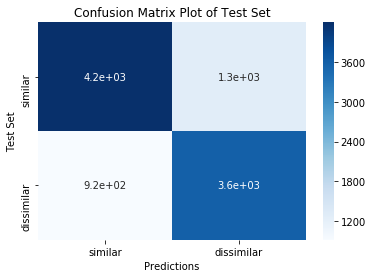

TP: 4193
FP: 923
FN: 1292
TN: 3592

Percision Score: 0.7354627354627354
Recall Score: 0.7955703211517166
F1 Score: 0.7643366315565485


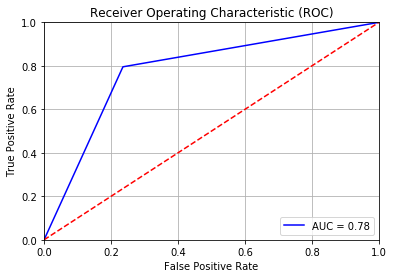

In [24]:
trainer.test()

### Comments on evaluation metrics

##### Best Result
- The best results were achieved with a the following hyperparameters:
    - hparams = {
            'threshold': torch.Tensor([0.5]),
            'learning_rate': 1e-03,
            'epoch': 50,
            'batch_size': 32,
            'hidden_dim': 100,
            'embedding_dim': 300,
            'dropout': 0.0,
            'remove_stopwords': False,
            'stem_words': False,
            'simple': True,
            'log_to_wandb': True,
        }
        
**NOTE: To find the optimal hyperparameters one could implement a grid search for example. 

##### Metrics 
There are several metrics that one can use to evaluate a binary classification tasks. I looked at are accuracy, the confusion matrix, F1 score and ROC curve to evaluate the performance of my model. 
1. Accuracy: The accuracy displays the percentage of of predictions the model gets correct. My model achieves an accuracy between 65 and 78% depending on the hyperparameters used.
        
2. Confusion Matrix: Sometimes, the accuracy of a classification task alone can be missleading if one has an unequal number of obersevations in each class. The confusion matrix can summaries the overall performance of the classification better by dispalying what is correctly classified, i.e. true positive and true negative, and what is being incorrectly classified, i.e. false positive and false negative [1]. 

3. F1 Score: The F1-score is often as a binary classification metrics of the model's test accuracy. It is calculated using precision `(TP/(TP + FP))` and recall `(TP/(TP + FN))` [1]. 
$$F1 = 2*\frac{precision*recall}{precision + recall}$$
If the F1 score is 0, the model performance is poor, i.e. all predicitons are wrong. If the F1 score is 1, all the predictions are correct. The F1-Score of my model consistenly achieves more then 0.7, which is indicating a relatively good model performance.

4. ROC Curve: Another common binary classification metric is the ROC-curve (Receiver operating characteristics curve): It displays the performanceof the model at all classification thresholds. It plots the True Positive Rate (TPR) vs the False Positive Rate (FPR). The Area Under the Curve (AUC) metric provides an aggregate measure of performance across all classification thresholds [1]. Advantages of AUC: 
    - it is scale invariant 
    - it is classification threshold invariant 
    
Concluding all these metrics can be used to evaluate the performance of a binary classification model. The results of each metric indicates the the implemented Siamese LSTM general performs relatively well on this task. 

[1] https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

#### Checkout random sample from training data

In [26]:
ind = np.random.choice(len(train_dataloader))
test_sample_train = dict()
for idx, batch in enumerate(train_dataloader):
    if idx == ind:
        test_sample_train['q1_text'] = [batch['q1_text'][0]]
        test_sample_train['q2_text'] = [batch['q2_text'][0]]
        test_sample_train['q1_token'] = [batch['q1_token'][0]]
        test_sample_train['q2_token'] = [batch['q2_token'][0]]
        test_sample_train['q1_lengths'] = [batch['q1_lengths'][0]]
        test_sample_train['q2_lengths'] = [batch['q2_lengths'][0]]
        test_sample_train['labels'] = [batch['labels'][0]]

In [27]:
trainer.predict(test_sample_train)

question 1: ['what are the names of these plants']
question 2: ['what is the name of plant']
tokens  q1: [[1, 2, 23, 3465, 37, 205, 6958]]
tokens  q2: [[1, 22, 23, 62, 37, 254]]


Model predicts 0.0 --> Actual value 0.0
Model prediction is correct :)

The questions ['what are the names of these plants'] and ['what is the name of plant'] are dissimilar!


#### Checkout random sample from validation data

In [28]:
ind = np.random.choice(len(val_dataloader))

test_sample_val = dict()
for idx, batch in enumerate(val_dataloader):
    if idx == ind:
        test_sample_val['q1_text'] = [batch['q1_text'][0]]
        test_sample_val['q2_text'] = [batch['q2_text'][0]]
        test_sample_val['q1_token'] = [batch['q1_token'][0]]
        test_sample_val['q2_token'] = [batch['q2_token'][0]]
        test_sample_val['q1_lengths'] = [batch['q1_lengths'][0]]
        test_sample_val['q2_lengths'] = [batch['q2_lengths'][0]]
        test_sample_val['labels'] = [batch['labels'][0]]

In [29]:
trainer.predict(test_sample_val)

question 1: ['who is the real pirate king']
question 2: ['how do pirates divide the stolen goods']
tokens  q1: [[40, 22, 23, 1169, 1832, 1167]]
tokens  q2: [[10, 18, 1833, 1834, 23, 1835, 1836]]


Model predicts 0.0 --> Actual value 0.0
Model prediction is correct :)

The questions ['who is the real pirate king'] and ['how do pirates divide the stolen goods'] are dissimilar!


#### Predict from custom input questions

In [30]:
default = True  # set to False to create your own inputs
similar = False  # select False to dispaly dissimlar example

if default:
    if similar:
        q1 = ['Is it cold today?']
        q2 = ['Will it be cold today?']
        label = [1.0]
    else:
        q1 = ['Will I pass the final?']
        q2 = ['What will I have for dinner tonight?']
        label = [0.0]
else:
    q1 = input(r'Enter your 1^st question: ')
    q2 = input(r'Enter your 2^nd question: ')
    label = input('label: ') # 0 for dissimilar, 1 for similar 
    q1 = [q1]
    q2 = [q2]
    label = [label]

In [31]:
# prepair custom input
# create df
df_own = pd.DataFrame(list(zip(q1, q2, label)), columns=['question1', 'question2', 'is_duplicate'])
# prepare data 
q_pair_own, label = convert_data_to_tuples(df_own, hparams['remove_stopwords'], hparams['stem_words'])
print(q_pair_own)

# create dataset 
own_dataset = QuoraDataset(q_pair_own, language.word2index, label)

# create dataloader
predict_dataloader = torch.utils.data.DataLoader(own_dataset, batch_size=1, collate_fn=collate)

for sample in predict_dataloader:
    test_sample = sample

# predict 
trainer.predict(test_sample)


Question Pairs:  1
[('will i pass the final', 'what will i have for dinner tonight')]
question 1: ['will i pass the final']
question 2: ['what will i have for dinner tonight']
tokens  q1: [[41, 12, 1487, 23, 1303]]
tokens  q2: [[1, 41, 12, 165, 63, 4425, 11626]]


Model predicts 0.0 --> Actual value 0.0
Model prediction is correct :)

The questions ['will i pass the final'] and ['what will i have for dinner tonight'] are dissimilar!


### Feedback:
- I think the task was very interesting and had a good degree of difficulty 
- One of my first NLP projects so I learned quite a lot, also about concepts I was not to confident with before, like embeddings 
- I initially struggeled a little bit with the implementation of a Siamese Network, maybe discuss such a specific topic next time also a little bit more in the Intro Sessions, maybe also some theoretical aspects
- Clear instructions and well prepared notebook

**Submission Notes:**

1. You can surely use external files to organize your code in classes or modules (e.g. `.py` files). However, please make sure that the notebook can run without errors and all the required files are attached in your submission (e.g. .zip file). If everything is confined in one single notebook, just submit the notebook.
2. If you use special libraries or packages, please indicate that clearly and add a `requirements.txt` file to your submission.
3. Do not upload the dataset nor submit it in any way.
4. Please do not copy code from someone else, the idea here is that you get a chance to write some code in PyTorch and solve the problem on your own. On the other hand, discuss with your colleagues and support them as much as needed. 
5. You can of course reuse the code in all the notebooks of the course.
6. You can also use code and/or ideas from the internet (e.g. Kaggle notebooks), but please always do the following:
    - make sure you understand the code so that you can use it correctly
    - cite the source in your notebook as markdown or as a comment in the code (`# adopted from .......`) 


**Evaluation Criteria:**

The most important idea we will use for evaluation is that you should get every component of the complete pipeline (1) doing what it is supposed to do and (2) fitting with the other components.

Concrete Examples are:
1. Your code runs and we can reproduce the results.
2. Dataset: Your code reads the dataset, preprocesses it, splits the text into tokens, etc...
3. Dataloading: Your dataset and dataloader produce correct inputs and labels (two questions as input, one binary label).
4. Model: Your model takes the input (processes each question correctly) and produces a binary prediction (or score).
5. Loss: your chosen loss is suitable for the task (e.g. binary cross entropy in case of the simple classification setup).
6. Training: your code for training and validation works without errors and the loss on the training and validation data decreases over the course of training. You do not have to achieve a specific performance.
7. Evaluation: you discuss the results and pick correctly some questions from train and validation and show the respective predictions (preferably showing the original question text and not the encoded integer sequence)

**Bonus:**
If you do any of the following ideas, you get a bonus, additionally you get to learn more, which is better than the bonus:

1. Build a baseline model to compare and benchmark your deep learning model against. You can in this case use a classical machine learning model from `scikit-learn`. A starter example is here: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
2. Use W&B or Tensorboard to visualize your training. TensorBoard tutorial is available here: (https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)
3. Achieve a relatively good performance on the task.
4. Use a learning rate scheduler to improve training. (https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
5. Use pre-trained embeddings correctly.
6. Use an advanced loss suitable for a siamese-network.
7. Implement any relevant new idea or discuss an interesting insight about the task.